In [1]:
%env OMP_NUM_THREADS=1
# або
import os
os.environ["OMP_NUM_THREADS"] = "1"

env: OMP_NUM_THREADS=1


In [2]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
import os
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
img = cv2.imread('source//Strada_Provinciale_BS_510_Sebina_Orientale.jpg')

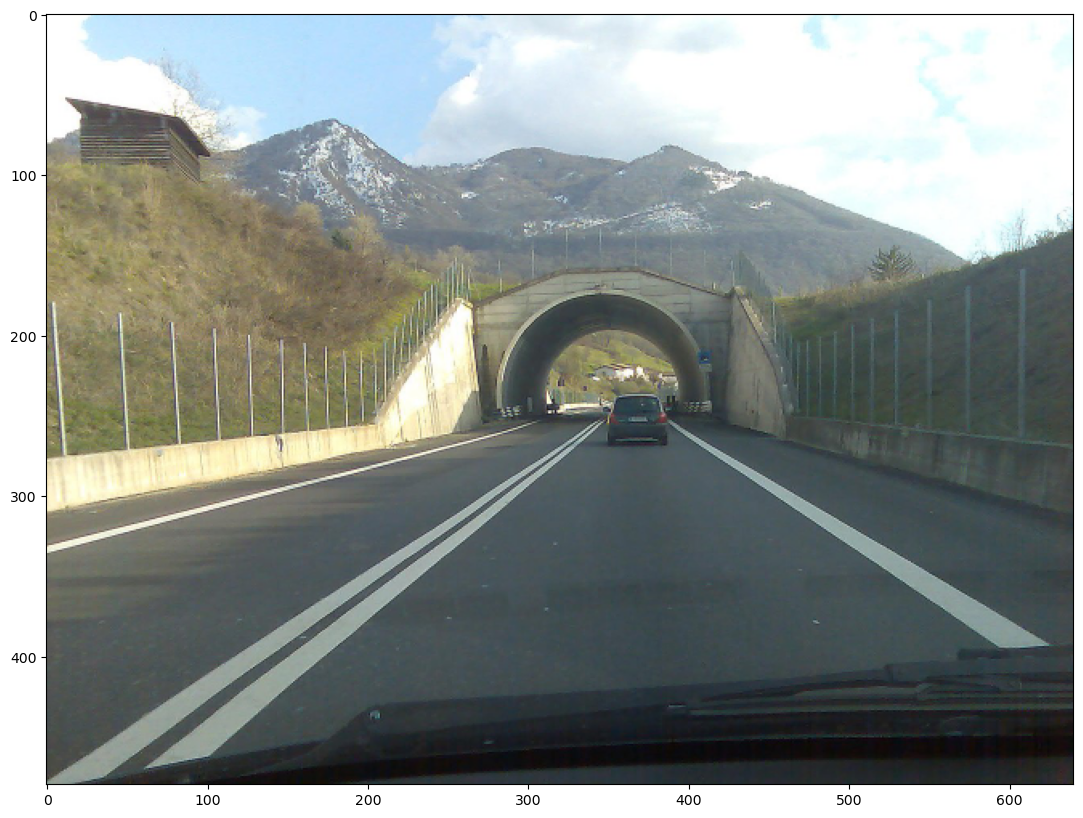

In [4]:
#load and show the camera frame.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

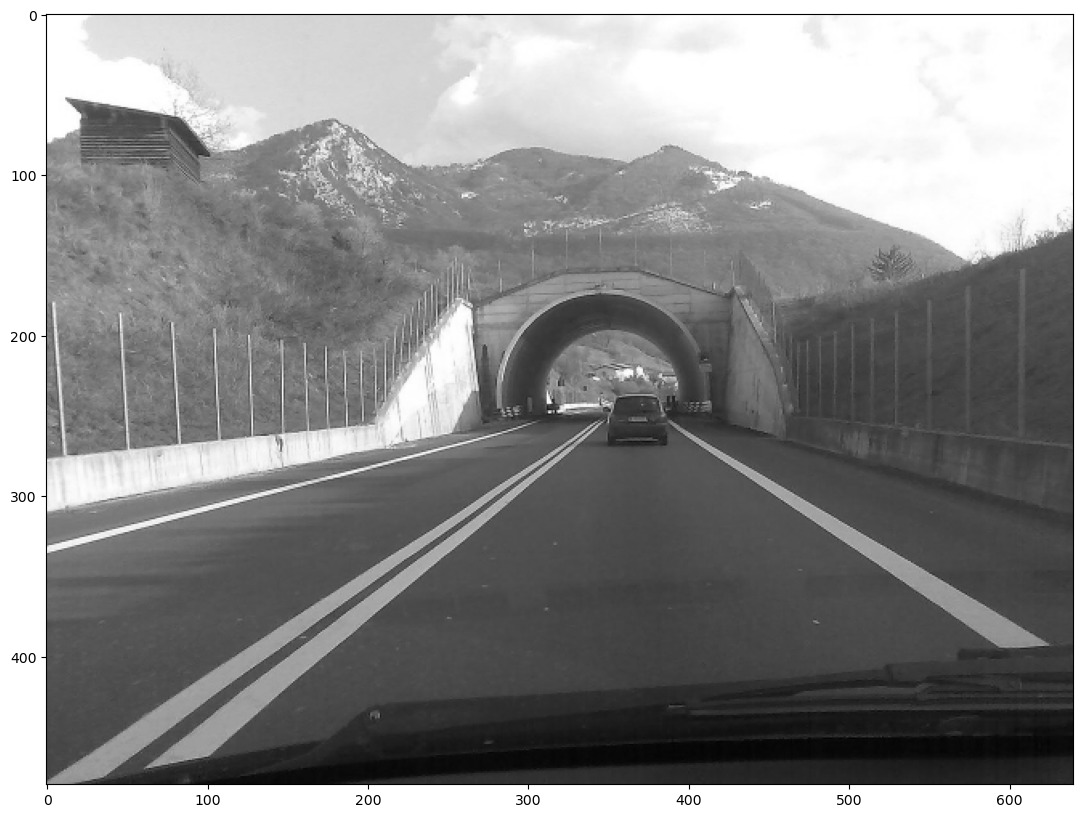

In [5]:
#convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

In [6]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
#edges = cv2.Canny(gray, 100, 150, apertureSize=3)
edges = cv2.Canny(gray, threshold1=100, threshold2=150)
print(edges.shape)
# We are only interseted in the road so we will remove everything above the horizon
cropped_edges = edges.copy()
cropped_edges[0:300] = 0

(480, 640)


(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

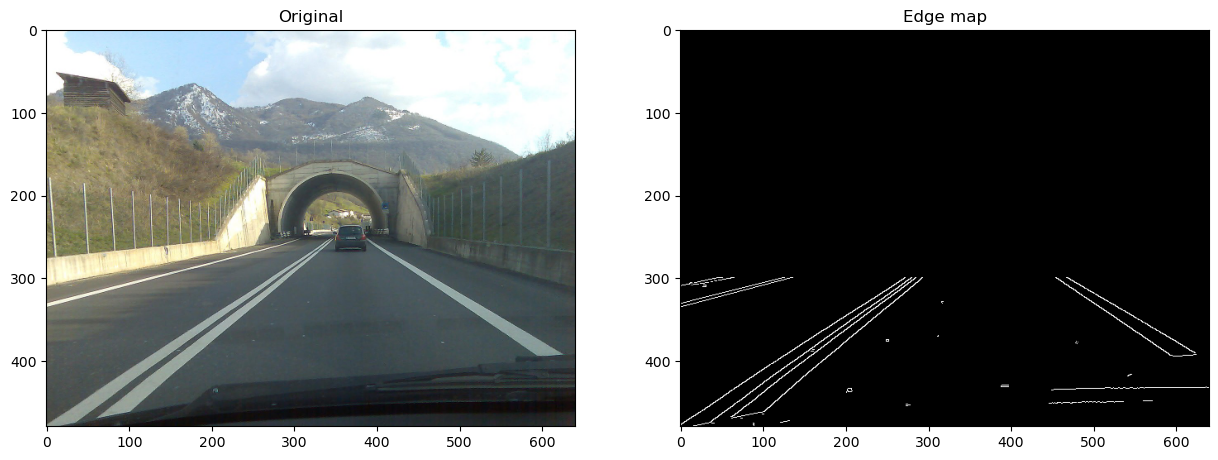

In [7]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(cropped_edges, cmap='gray'), plt.title('Edge map')

In [8]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLines(cropped_edges, rho=2, theta=2*np.pi/180, threshold=120)

# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]
print(f"Number of lines: {len(lines)}")

Number of lines: 15


(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

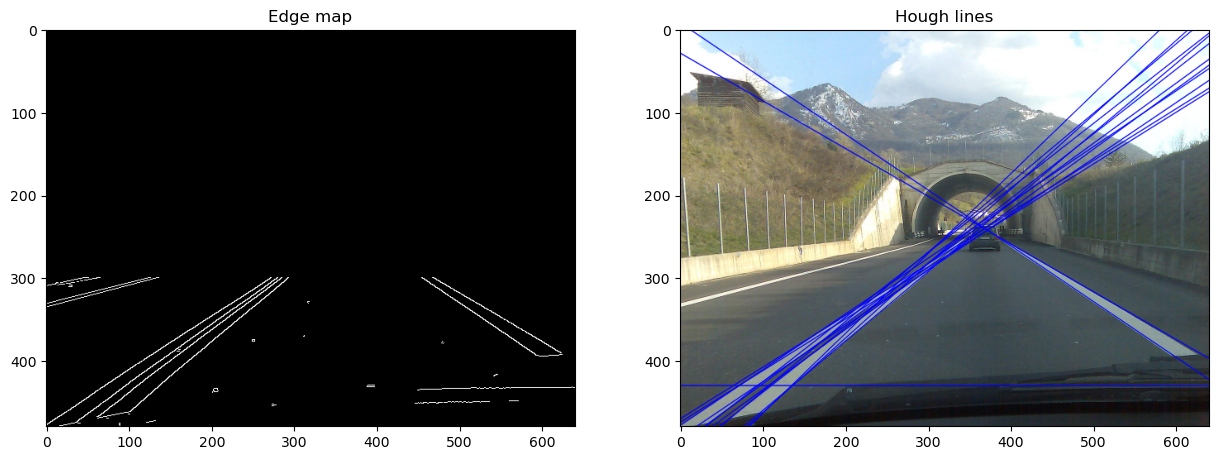

In [9]:
# Plot the resulting Hough lines
result_hl = np.copy(img)
        
for line in lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result_hl, pt1, pt2, (0, 0, 255), 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(cropped_edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result_hl, cmap='gray'), plt.title('Hough lines')

In [10]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta0 = 20 * np.pi / 180   # Keep line if theta is not horizontal
    #if line[1] < (np.pi/2 - theta0) or line[1] > (np.pi/2 + theta0):
    if np.abs(line[1]-np.pi/2)>theta0:
        filtered_lines.append(line)
print(f"Number of filtered lines: {len(filtered_lines)}")

Number of filtered lines: 14


(<Axes: title={'center': 'Theta-filtered lines'}>,
 Text(0.5, 1.0, 'Theta-filtered lines'))

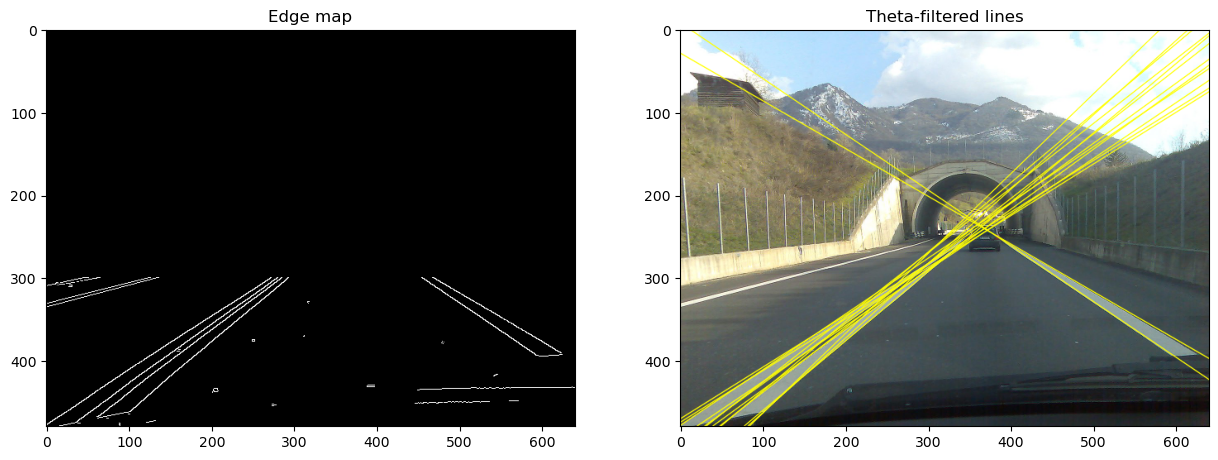

In [11]:
# Let's plot the resulting filtered lines
result_fl = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result_fl, pt1, pt2, (255, 255, 0), 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(cropped_edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result_fl, cmap='gray'), plt.title('Theta-filtered lines')

(<Axes: title={'center': 'Cluster-filtered lines'}>,
 Text(0.5, 1.0, 'Cluster-filtered lines'))

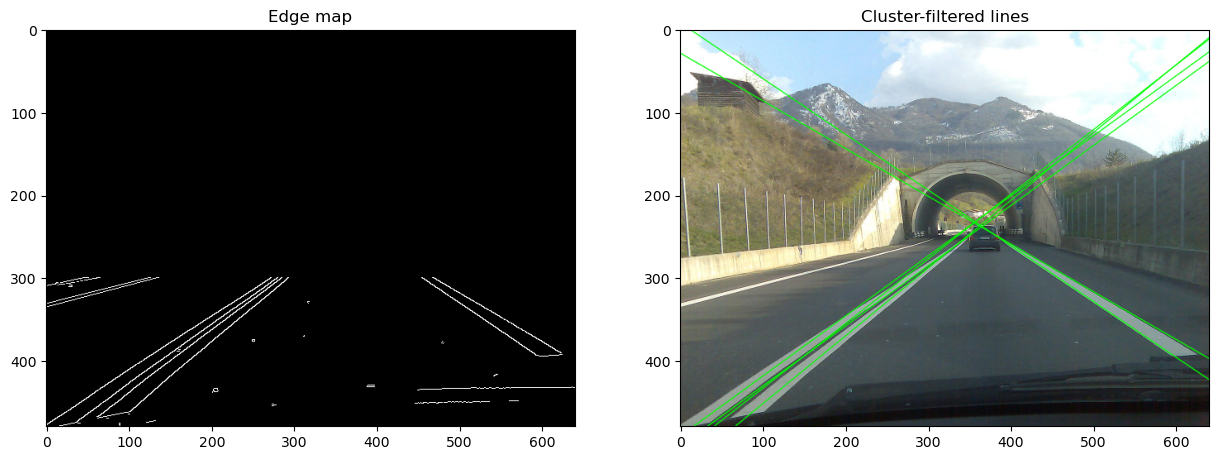

In [12]:
# Відбираємо групи подібних ліній (кластерів)
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

# Again, let's plot the resulting filtered lines
result_cl = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result_cl, pt1, pt2, (0, 255, 0), 1, cv2.LINE_AA)
    
plt.subplot(121), plt.imshow(cropped_edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result_cl, cmap='gray'), plt.title('Cluster-filtered lines')

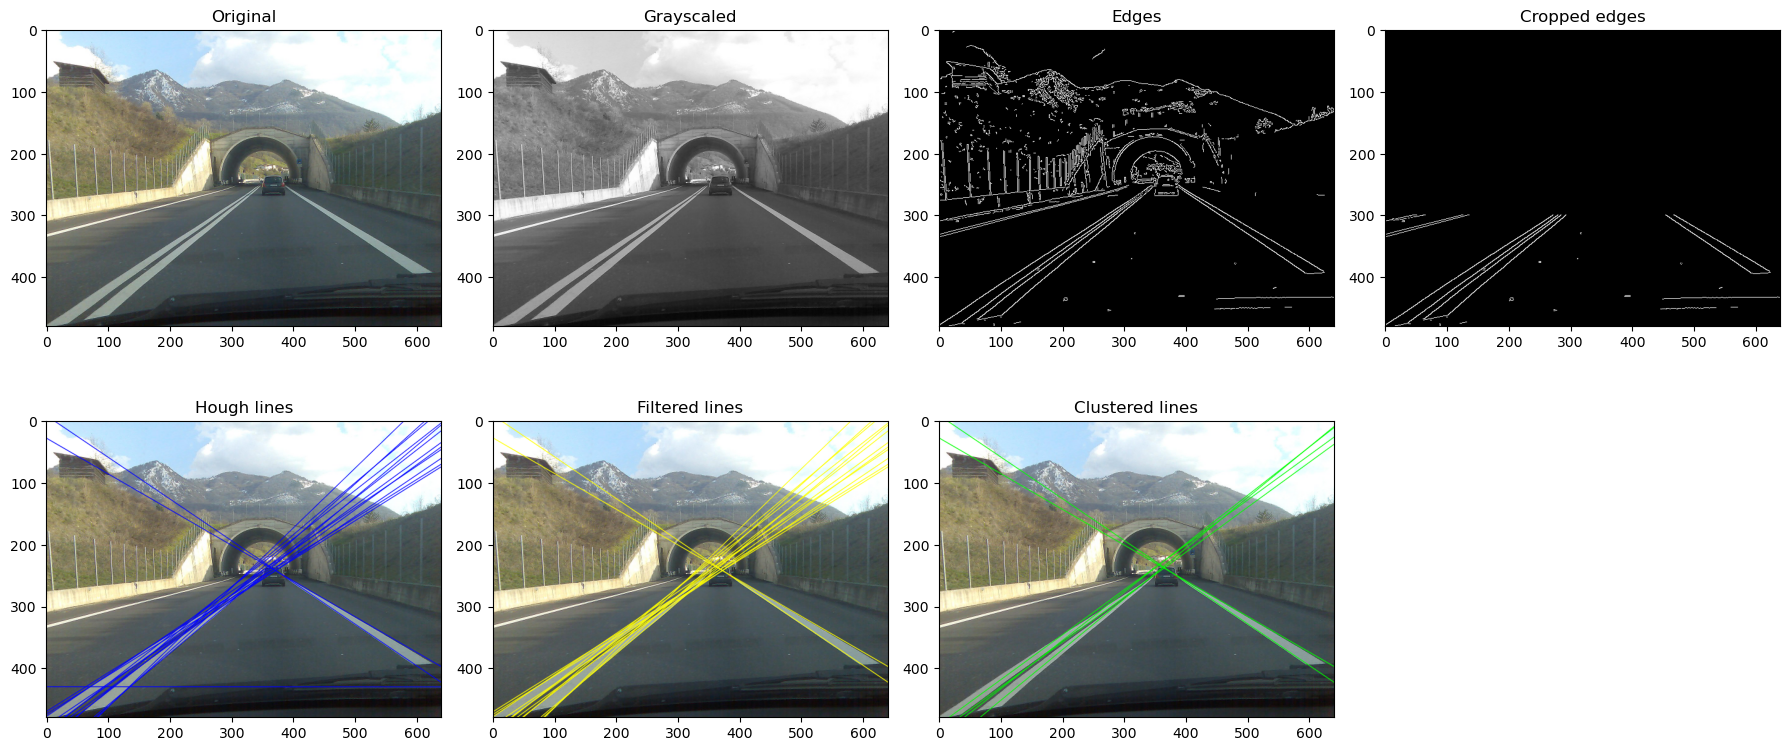

In [13]:
# Let's summarize all steps in one pipe-line plot
plt.rcParams['figure.figsize'] = [18, 8]
plt.subplot(241), plt.imshow(img), plt.title('Original')
plt.subplot(242), plt.imshow(gray, cmap='gray'), plt.title('Grayscaled')
plt.subplot(243), plt.imshow(edges, cmap='gray'), plt.title('Edges')
plt.subplot(244), plt.imshow(cropped_edges, cmap='gray'), plt.title('Cropped edges')
plt.subplot(245), plt.imshow(result_hl), plt.title('Hough lines')
plt.subplot(246), plt.imshow(result_fl), plt.title('Filtered lines')
plt.subplot(247), plt.imshow(result_cl), plt.title('Clustered lines')


#Зберігаємо результат
out_path = "Lesson4/result/pipline.png"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
plt.tight_layout()
plt.savefig(out_path, dpi=200, bbox_inches="tight")

Do you see anything strange in the final result?
Так, усі лінії розмітки мали б сходититсь в одній точці сходження (по закону перспективи), 
    але в наслідок невеликих помилок, зокрема під час розпізнавання меж, відбуваються незначні відхилення по куту нахилу ліній
    

Do you think the Hough transform resolution is important for obtaining a good result? Why?
Чим більше роздільна здатність при трансформації Гофа, тим точніше буде визначено лінії


Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?
Порогові значення при селекції результатів трансформації Гофа важливі для відсічення непотрібних ліній 
(або занадто довги, або занадто коротких)